## Thermal conductivity model - BPC model
- The script is written based on the article - https://gmd.copernicus.org/articles/8/2701/2015/ (Appendix A - Thermal conductivity model) 
- Author: Radhakrishna.B.L.
- Code from Ethan coon is taken- https://github.com/amanzi/ats/blob/master/tools/python_models/thermal_conductivity2.ipynb

The BPC model is described first by this equation:

\begin{equation}
    \kappa_e = K_{e,f} \kappa_{sat,f} -  K_{e,u} \kappa_{sat,u} + (1 - K_{e,u} - K_{e,f})\kappa_{dry} 
\end{equation}

Here, $\kappa$ is the thermal conductivity & K_{sat} is the Kersten number. Subscripts {e, f, u, dry} represents {medium, frozen, unfrozen, and dry}.

The Kersten number for frozen and unfrozen is determined by a power law function defined in Painter, 2011. It relates the kersten number to saturation of liquid. 

\begin{equation}
    K_{e,u} = (s_l + \epsilon)^{\alpha_u}
\end{equation}

\begin{equation}
    K_{e,f} = (s_l + \epsilon)^{\alpha_f}
\end{equation}

It is assumed that $\kappa_{sat, u}$ is known (either measured or calibrated with temperature measurements). To determine the thermal conductivity at a frozen state, we can use the following equation:

\begin{equation}
    \kappa_{sat, f} = \kappa_{sat, u} (\frac{\kappa_i}{\kappa_w})^{\phi}
\end{equation}

where $\kappa_i$ and $\kappa_w$ is the thermal conductivity of ice and water. 

Here are all the equations:

\begin{equation}
    \kappa_e = K_{e,f} \kappa_{sat,f} -  K_{e,u} \kappa_{sat,u} + (1 - K_{e,u} - K_{e,f})\kappa_{dry} 
\end{equation}

\begin{equation}
    K_{e,u} = (s_l + \epsilon)^{\alpha_u}
\end{equation}

\begin{equation}
    K_{e,f} = (s_l + \epsilon)^{\alpha_f}
\end{equation}

\begin{equation}
    \kappa_{sat, f} = \kappa_{sat, u} (\frac{\kappa_i}{\kappa_w})^{\phi}
\end{equation}

### Outcomes from plotting and studying the equation:
- There are five main unknowns - Thermal conductivity saturated (unfrozen), Thermal conducitivity dry, $alpha_f$, $alpha_uf$, and porosity.
- Thermal conductivity saturated (unfrozen) has the greatest impact on the TCM model.
- Depending on the condition: frozen or unfrozen - the next impactful parameters $\alpha_f$ and $\alpha_u$. It can also be that porosity is an important parameter.
- Thermal conductivity dry is the least impactful parameter.



In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors as ml_colors
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import os,sys
import scipy as sp
import colors

#sys.path.append('/home/ecoon/research/python')
#import colors

In [3]:
# This is the model used in ATS - Freezeup
class ThreePhaseWetDry():
    """
    To determine the thermal conductivity of the soil based on the MPC model - Three phase wet/dry
    
    PARAMETERS:
    
    ------
    INPUT:
    
    a_u - unsaturated alpha unfrozen [-]. Typical value = 0.5 (Source: freezeup.xml)
        
    a_f - unsaturated alpha frozen [-]. Typical value = 1 (Source: freezeup.xml)
    
    
    tc_dry - Dry thermal conductivity [W m^-1 K^-1]. Typical values are: 0.07 - peat, 0.29 - mineral (Source: freezeup.xml)
    
    tc_sat_u - Unfrozen saturated thermal conductivity [W m^-1 K^-1]. Typical values are: 0.67 - peat, 1.0 - mineral (Source: freezeup.xml)
    
    poro - porosity of the material. Typical value is 0.85 for peat and [0.2 - 0.5] for mineral
    
    s_r - Residual saturation. Typical values vary from 0.05 for peat to [0.1 - 0.3] for clay/sand/silt
    
    sl - Saturation of liquid- Needs to be calculated based on three cases - unfrozen, frozen and transition 
    
    si - Saturation of ice- Needs to be calculated based on three cases - unfrozen, frozen and transition 
    
    OUTPUT:
    
    The thermal conductivity of the medium
    
    """
    # Defining the constants in the equations - as per the code from Ethan 
    eps_ = 1.e-10
    
    def __init__(self, tc_sat_uf, tc_dry, a_f, a_u):
        self.a_u = a_u
        self.a_f = a_f
        self.tc_sat_uf = tc_sat_uf
        self.tc_dry = tc_dry
    def thermal_conductivity(self, poro, sl, si, T):
        
        self.poro = poro
        
        # Thermal conductivity of ice
        Ki = 831.51 * pow(T, -1.0552)
        
        # Thermal conductivity of liquid
        Kl = 0.5611;
        
        # Saturated thermal conductivity - frozen
        tc_sat_f = self.tc_sat_uf * pow(Ki/Kl, self.poro);

        kersten_u = pow(sl + self.eps_, self.a_u);
        kersten_f = pow(si + self.eps_, self.a_f);
        
        return kersten_f * tc_sat_f + kersten_u * self.tc_sat_uf + (1.0 - kersten_f - kersten_u) * self.tc_dry;
    
    def plot_end_members(self, poro, s_r, axs=None, color='k', label=None, npoints=1000):
        if axs is None:
            fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
            fig.set_size_inches(24, 8)
            #fig.title('Test')

    
            # unfrozen
            sle = np.linspace(0,1,npoints)
            sl = sle*(1-s_r) + s_r
            si = 0
            tc_u = np.array([self.thermal_conductivity(poro, s, si, 275.) for s in sl])
            ax1.plot(sle, tc_u, color=color, label=label)
            ax1.set_xlabel("1 - reduced gas saturation ")
            ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
            ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]")
            ax1.grid(True)

            # frozen
            sie = np.linspace(0,1,1000)
            si = sie*(1-s_r)
            tc_f = np.array([self.thermal_conductivity(poro, s_r, s, 260.0) for s in si])
            ax2.plot(sie, tc_f, color=color, label=label)
            ax2.set_xlabel("1 - reduced gas saturation")
            ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
            ax2.grid(True)
            #ax3.set_ylabel("thermal conductivity")

            # transition
            sie = np.linspace(0,1,1000)
            si = sie*(1-s_r)
            tc_t = np.array([self.thermal_conductivity(poro, 1-s, s, 260.0) for s in si])
            ax3.plot(sie, tc_t, color=color, label=f'tc_sat_uf={self.tc_sat_uf}, tc_dry={self.tc_dry}, por = {self.poro}, a_f = {self.a_f}, a_u = {self.a_u}')
            ax3.set_xlabel("reduced ice saturation")
            #ax3.set_ylabel("thermal conductivity")
            ax3.set_title("Transition: sg = 0")
            ax3.legend()
            ax3.grid(True)

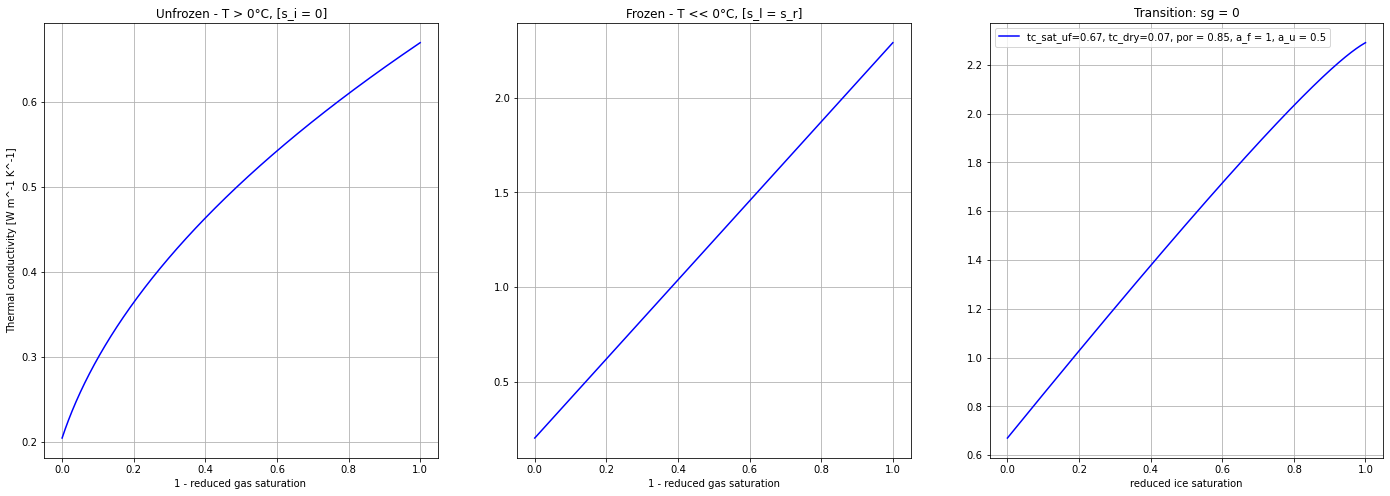

In [4]:
# Trial
tc_peat = ThreePhaseWetDry(0.67, 0.07, 1, 0.5)
tc_peat.plot_end_members(0.85, 0.05, color='b')
#tc_peat.plot_end_members(0.5, 0.2)

## Plotting the parameters:
* Peat:
    - Ppor - Porosity : [0.3, 0.5, 0.9] 
    - Ptcs - Thermal conductivity, saturated (unfrozen) : [0.2, 0.6, 1]
    - Ptcd - Thermal conductivity, dry : [0.03, 0.07, 0.12]
    - Paf - [0.5, 1.0, 1.5]
    - Pauf - [0.1, 0.5, 0.7]
* Mineral:
    - Mpor - Porosity : [0.2, 0.3, 0.5] 
    - Mtcs - Thermal conductivity, saturated (unfrozen) : [1, 1.5, 2.0]
    - Mtcd - Thermal conductivity, dry : [0.2, 0.6, 1.0]
    - Maf - [0.5, 1.0, 1.5]
    - Mauf - [0.1, 0.5, 0.7] 
* Bedrock:
    - Bpor - Porosity : [1.5, 2.0, 3.0] 
    - Btcs - Thermal conductivity, saturated (unfrozen) : [1, 1.5, 2.0]
    - Btcd - Thermal conductivity, dry : [0.5, 1.0, 1.5]
    - Baf - [0.5, 1.0, 1.5]
    - Bauf - [0.1, 0.5, 0.7] 
 
**The standard values is always the second value**

In [5]:
# Standard parameters for all cases: - Check out Excel sheet - C:\Users\radhakrishna\OneDrive\Documents\Hannover_PhD\Work\ATS\RKModel\RKModel_info_simulation_strategy.xlsx

# Peat
Ptcs_std = 0.6
Ptcd_std = 0.07
Paf_std = 1 
Pauf_std = 0.5
Ppor_std = 0.5

# Mineral
Mtcs_std = 1.5
Mtcd_std = 0.6
Maf_std = 1 
Mauf_std = 0.5
Mpor_std = 0.3

# Bedrock
Btcs_std = 2
Btcd_std = 1.0
Baf_std = 1.0 
Bauf_std = 0.5
Bpor_std = 0.3


In [6]:
# Variation of parameters: Check out Excel sheet - C:\Users\radhakrishna\OneDrive\Documents\Hannover_PhD\Work\ATS\RKModel\RKModel_info_simulation_strategy.xlsx

# Peat
Ptcs = [0.2, 0.6, 1.0]
Ptcd = [0.03, 0.07, 0.12]
Paf = [0.5, 1.0, 1.5] 
Pauf = [0.1, 0.5, 0.7]
Ppor = [0.3, 0.5, 0.9]

# Mineral
Mtcs = [1, 1.5, 2]
Mtcd = [0.2, 0.6, 1.0]
Maf = [0.5, 1, 1.5] 
Mauf = [0.1, 0.5, 0.7]
Mpor = [0.2, 0.3, 0.5]

# Bedrock
Btcs = [1.5, 2, 3]
Btcd = [0.5, 1, 1.5]
Baf = [0.5, 1, 1.5] 
Bauf = [0.1, 0.5, 0.7]
Bpor = [0.2, 0.3, 0.5]

### Porosity

In [7]:
# Test
tc_test = ThreePhaseWetDry(Ptcs_std, Ptcd_std, Paf_std, Pauf_std)
tc_test.thermal_conductivity(poro=0.2, sl=0.5,si=0.3, T =260)

0.6635294877533005

### Peat

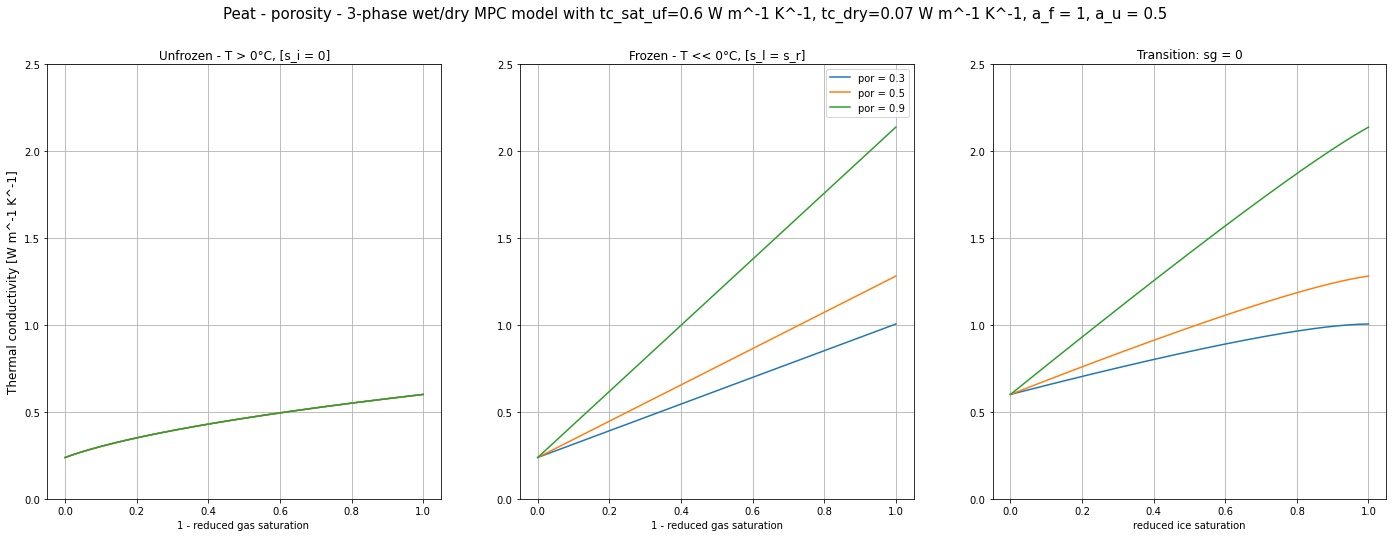

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(24, 8)
fig.suptitle(f'Peat - porosity - 3-phase wet/dry MPC model with tc_sat_uf={Ptcs_std} W m^-1 K^-1, tc_dry={Ptcd_std} W m^-1 K^-1, a_f = {Paf_std}, a_u = {Pauf_std}', fontsize=15)

# Defining a color label
color_label_water = colors.cm_mapper(vmin=0.0, vmax=3.0, cmap=colors.water_cmap())

# Defining the number of points for the variation of saturation of liquid
npoints = 1000
# Residual saturation
s_r = 0.1

# Creating an object - peat
tc_Ppor = ThreePhaseWetDry(Ptcs_std, Ptcd_std, Paf_std, Pauf_std)
    
# unfrozen
sle = np.linspace(0, 1, npoints)
sl = sle*(1-s_r) + s_r
si = 0

tc_u_1 = np.array([tc_Ppor.thermal_conductivity(Ppor[0], s, si, 275.) for s in sl])
tc_u_2 = np.array([tc_Ppor.thermal_conductivity(Ppor[1], s, si, 275.) for s in sl])
tc_u_3 = np.array([tc_Ppor.thermal_conductivity(Ppor[2], s, si, 275.) for s in sl])

ax1.plot(sle, tc_u_1, label=f'por = {Ppor[0]}')
ax1.plot(sle, tc_u_2, label=f'por = {Ppor[1]}')
ax1.plot(sle, tc_u_3, label=f'por = {Ppor[2]}')

ax1.set_xlabel("1 - reduced gas saturation ")
ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]", fontsize=12)
ax1.set_ylim(0,2.5)
ax1.grid(True)
#ax1.legend()

# frozen
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

tc_f_1 = np.array([tc_Ppor.thermal_conductivity(Ppor[0], s_r, s, 260.0) for s in si])
tc_f_2 = np.array([tc_Ppor.thermal_conductivity(Ppor[1], s_r, s, 260.0) for s in si])
tc_f_3 = np.array([tc_Ppor.thermal_conductivity(Ppor[2], s_r, s, 260.0) for s in si])

ax2.plot(sle, tc_f_1, label=f'por = {Ppor[0]}')
ax2.plot(sle, tc_f_2, label=f'por = {Ppor[1]}')
ax2.plot(sle, tc_f_3, label=f'por = {Ppor[2]}')

ax2.set_xlabel("1 - reduced gas saturation")
ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
ax2.grid(True)
ax2.legend()
ax2.set_ylim(0,2.5)
#ax3.set_ylabel("thermal conductivity")

# transition
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

tc_t_1 = np.array([tc_Ppor.thermal_conductivity(Ppor[0], 1-s, s, 260.0) for s in si])
tc_t_2 = np.array([tc_Ppor.thermal_conductivity(Ppor[1], 1-s, s, 260.0) for s in si])
tc_t_3 = np.array([tc_Ppor.thermal_conductivity(Ppor[2], 1-s, s, 260.0) for s in si])

ax3.plot(sle, tc_t_1, label=f'por = {Ppor[0]}')
ax3.plot(sle, tc_t_2, label=f'por = {Ppor[1]}')
ax3.plot(sle, tc_t_3, label=f'por = {Ppor[2]}')


ax3.set_xlabel("reduced ice saturation")
#ax3.set_ylabel("thermal conductivity")
ax3.set_title("Transition: sg = 0")
#ax3.legend()
ax3.set_ylim(0,2.5)
ax3.grid(True)

* Comments:
    - As the porosity increases, the thermal conductivity of the medium under frozen and transition conditions also increases
    - For the unfrozen state, the thermal conductivity remains constant since K_ef almost equal to 0

### Mineral

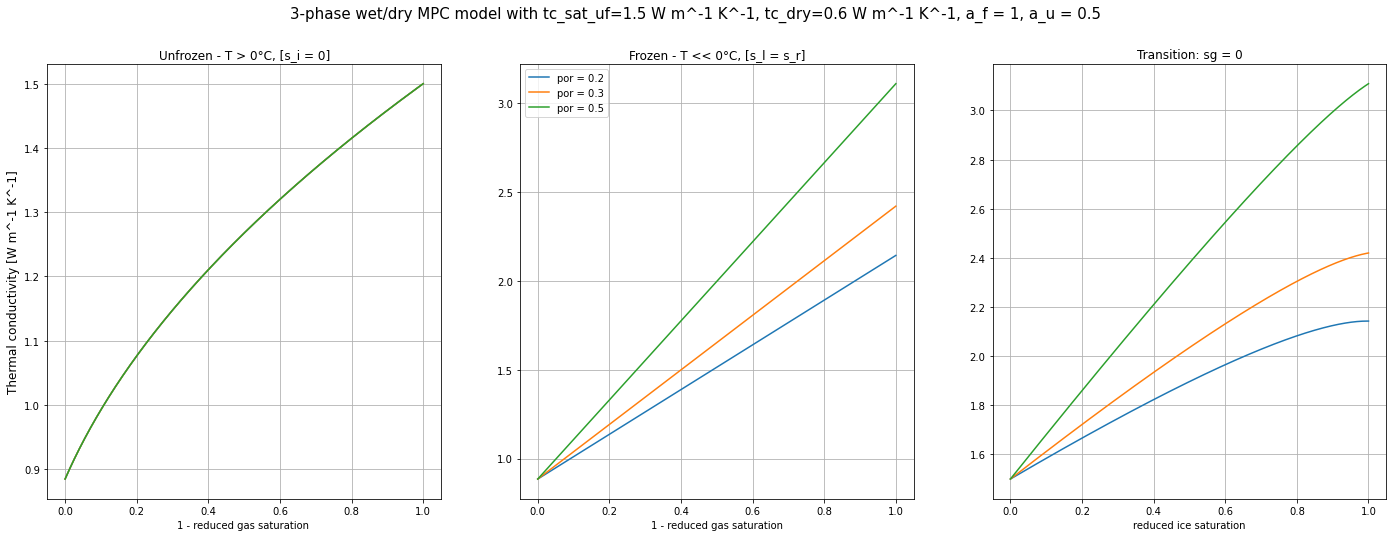

In [256]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(24, 8)
fig.suptitle(f'Mineral - porosity - 3-phase wet/dry MPC model with tc_sat_uf={Mtcs_std} W m^-1 K^-1, tc_dry={Mtcd_std} W m^-1 K^-1, a_f = {Maf_std}, a_u = {Mauf_std}', fontsize=15)

# Defining a color label
color_label_water = colors.cm_mapper(vmin=0.0, vmax=3.0, cmap=colors.water_cmap())


# Creating an object - peat
tc_Mpor = ThreePhaseWetDry(Mtcs_std, Mtcd_std, Maf_std, Mauf_std)
    
# unfrozen
sle = np.linspace(0, 1, npoints)
sl = sle*(1-s_r) + s_r
si = 0

tc_u_1 = np.array([tc_Mpor.thermal_conductivity(Mpor[0], s, si, 275.) for s in sl])
tc_u_2 = np.array([tc_Mpor.thermal_conductivity(Mpor[1], s, si, 275.) for s in sl])
tc_u_3 = np.array([tc_Mpor.thermal_conductivity(Mpor[2], s, si, 275.) for s in sl])

ax1.plot(sle, tc_u_1, label=f'por = {Mpor[0]}')
ax1.plot(sle, tc_u_2, label=f'por = {Mpor[1]}')
ax1.plot(sle, tc_u_3, label=f'por = {Mpor[2]}')

ax1.set_xlabel("1 - reduced gas saturation ")
ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]", fontsize=12)
ax1.grid(True)
#ax1.legend()

# frozen
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

tc_f_1 = np.array([tc_Mpor.thermal_conductivity(Mpor[0], s_r, s, 260.0) for s in si])
tc_f_2 = np.array([tc_Mpor.thermal_conductivity(Mpor[1], s_r, s, 260.0) for s in si])
tc_f_3 = np.array([tc_Mpor.thermal_conductivity(Mpor[2], s_r, s, 260.0) for s in si])

ax2.plot(sle, tc_f_1, label=f'por = {Mpor[0]}')
ax2.plot(sle, tc_f_2, label=f'por = {Mpor[1]}')
ax2.plot(sle, tc_f_3, label=f'por = {Mpor[2]}')

ax2.set_xlabel("1 - reduced gas saturation")
ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
ax2.grid(True)
ax2.legend()
#ax3.set_ylabel("thermal conductivity")

# transition
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

tc_t_1 = np.array([tc_Mpor.thermal_conductivity(Mpor[0], 1-s, s, 260.0) for s in si])
tc_t_2 = np.array([tc_Mpor.thermal_conductivity(Mpor[1], 1-s, s, 260.0) for s in si])
tc_t_3 = np.array([tc_Mpor.thermal_conductivity(Mpor[2], 1-s, s, 260.0) for s in si])

ax3.plot(sle, tc_t_1, label=f'por = {Mpor[0]}')
ax3.plot(sle, tc_t_2, label=f'por = {Mpor[1]}')
ax3.plot(sle, tc_t_3, label=f'por = {Mpor[2]}')


ax3.set_xlabel("reduced ice saturation")
#ax3.set_ylabel("thermal conductivity")
ax3.set_title("Transition: sg = 0")
#ax3.legend()
ax3.grid(True)

### Bedrock

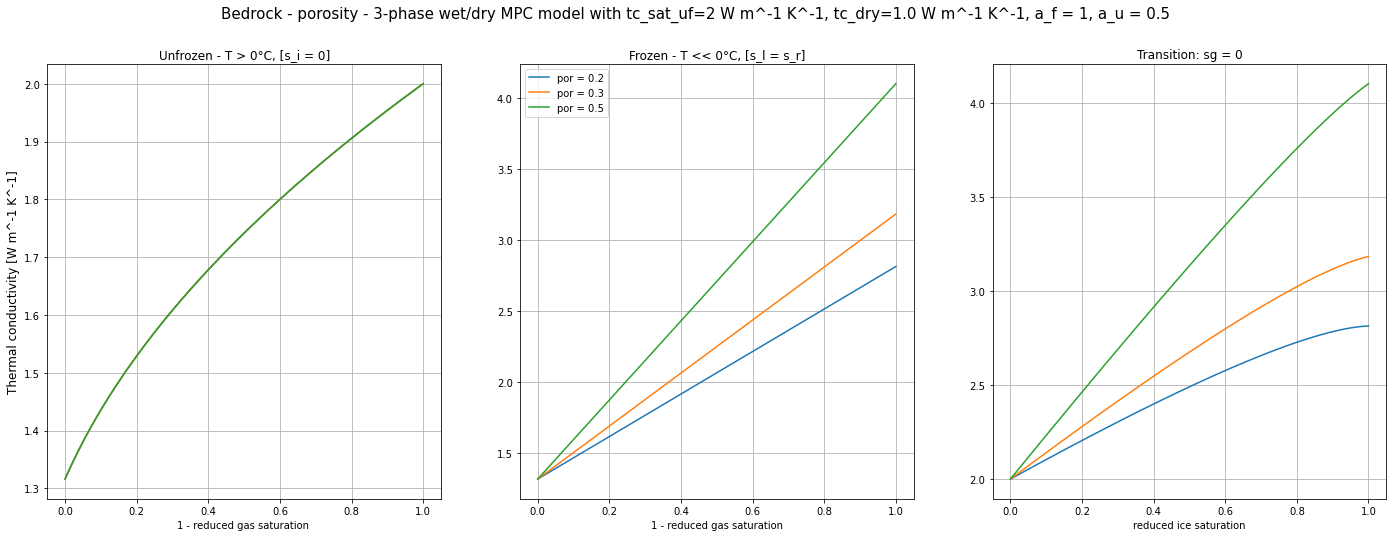

In [258]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(24, 8)
fig.suptitle(f'Bedrock - porosity - 3-phase wet/dry MPC model with tc_sat_uf={Btcs_std} W m^-1 K^-1, tc_dry={Btcd_std} W m^-1 K^-1, a_f = {Maf_std}, a_u = {Bauf_std}', fontsize=15)

# Defining a color label
color_label_water = colors.cm_mapper(vmin=0.0, vmax=3.0, cmap=colors.water_cmap())


# Creating an object - peat
tc_Bpor = ThreePhaseWetDry(Btcs_std, Btcd_std, Baf_std, Bauf_std)
    
# unfrozen
sle = np.linspace(0, 1, npoints)
sl = sle*(1-s_r) + s_r
si = 0

tc_u_1 = np.array([tc_Bpor.thermal_conductivity(Bpor[0], s, si, 275.) for s in sl])
tc_u_2 = np.array([tc_Bpor.thermal_conductivity(Bpor[1], s, si, 275.) for s in sl])
tc_u_3 = np.array([tc_Bpor.thermal_conductivity(Bpor[2], s, si, 275.) for s in sl])

ax1.plot(sle, tc_u_1, label=f'por = {Bpor[0]}')
ax1.plot(sle, tc_u_2, label=f'por = {Bpor[1]}')
ax1.plot(sle, tc_u_3, label=f'por = {Bpor[2]}')

ax1.set_xlabel("1 - reduced gas saturation ")
ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]", fontsize=12)
ax1.grid(True)
#ax1.legend()

# frozen
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

tc_f_1 = np.array([tc_Bpor.thermal_conductivity(Bpor[0], s_r, s, 260.0) for s in si])
tc_f_2 = np.array([tc_Bpor.thermal_conductivity(Bpor[1], s_r, s, 260.0) for s in si])
tc_f_3 = np.array([tc_Bpor.thermal_conductivity(Bpor[2], s_r, s, 260.0) for s in si])

ax2.plot(sle, tc_f_1, label=f'por = {Bpor[0]}')
ax2.plot(sle, tc_f_2, label=f'por = {Bpor[1]}')
ax2.plot(sle, tc_f_3, label=f'por = {Bpor[2]}')

ax2.set_xlabel("1 - reduced gas saturation")
ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
ax2.grid(True)
ax2.legend()
#ax3.set_ylabel("thermal conductivity")

# transition
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

tc_t_1 = np.array([tc_Bpor.thermal_conductivity(Bpor[0], 1-s, s, 260.0) for s in si])
tc_t_2 = np.array([tc_Bpor.thermal_conductivity(Bpor[1], 1-s, s, 260.0) for s in si])
tc_t_3 = np.array([tc_Bpor.thermal_conductivity(Bpor[2], 1-s, s, 260.0) for s in si])

ax3.plot(sle, tc_t_1, label=f'por = {Bpor[0]}')
ax3.plot(sle, tc_t_2, label=f'por = {Bpor[1]}')
ax3.plot(sle, tc_t_3, label=f'por = {Bpor[2]}')


ax3.set_xlabel("reduced ice saturation")
#ax3.set_ylabel("thermal conductivity")
ax3.set_title("Transition: sg = 0")
#ax3.legend()
ax3.grid(True)

### Thermal conductivity, saturated (unfrozen)

### Peat

In [25]:
# Generating the objects for different thermal conductivity value, saturated (unfrozen)
for i, value in enumerate(Ptcs):
    locals()[f'tc_Ptcs_{i}'] = ThreePhaseWetDry(value, Ptcd_std, Paf_std, Pauf_std)

In [26]:
tc_Ptcs_0.tc_sat_uf

0.2

(0.0, 2.2)

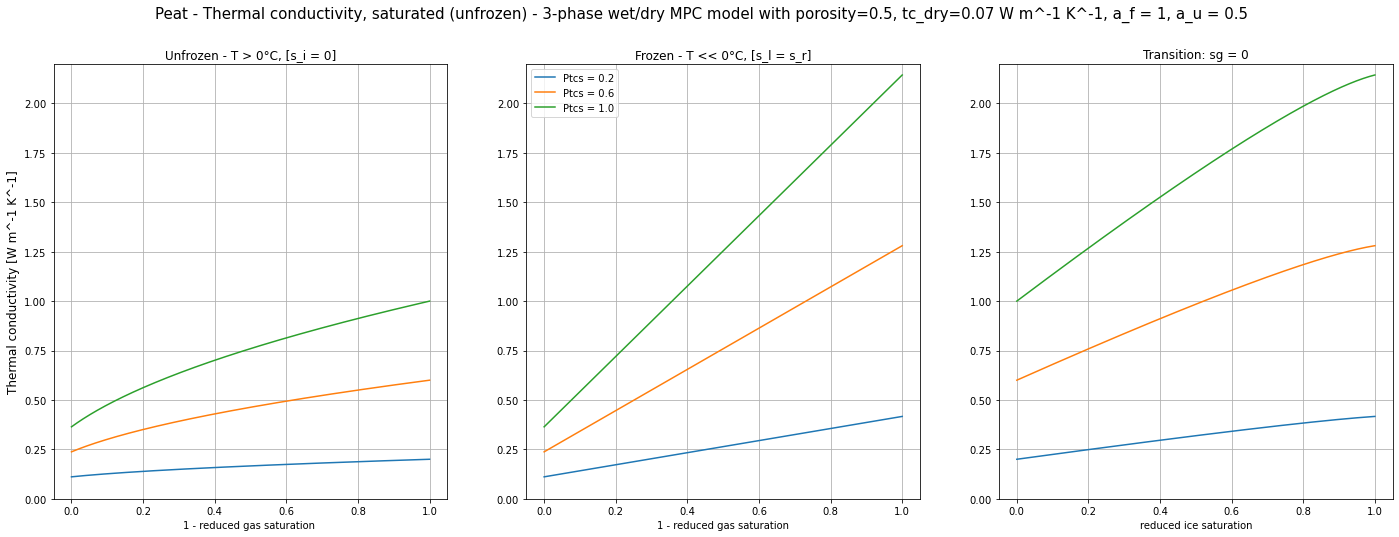

In [89]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(24, 8)
fig.suptitle(f'Peat - Thermal conductivity, saturated (unfrozen) - 3-phase wet/dry MPC model with porosity={Ppor_std}, tc_dry={Ptcd_std} W m^-1 K^-1, a_f = {Paf_std}, a_u = {Pauf_std}', fontsize=15)

# Defining a color label
color_label_water = colors.cm_mapper(vmin=0.0, vmax=3.0, cmap=colors.water_cmap())

# Defining the number of points for the variation of saturation of liquid
npoints = 1000
# Residual saturation
s_r = 0.1

    
# unfrozen
sle = np.linspace(0, 1, npoints)
sl = sle*(1-s_r) + s_r
si = 0

for i, value in enumerate(Ptcs):
    locals()[f'tc_Ptcs_u_{i}'] = np.array([globals()[f'tc_Ptcs_{i}'].thermal_conductivity(Ppor_std, s, si, 275.) for s in sl])
    ax1.plot(sle, locals()[f'tc_Ptcs_u_{i}'], label=f'Ptcs = {value}')

ax1.set_xlabel("1 - reduced gas saturation ")
ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]", fontsize=12)
ax1.grid(True)
#ax1.legend()
ax1.set_ylim(0, 2.2)

# frozen
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

for i, value in enumerate(Ptcs):
    locals()[f'tc_Ptcs_f_{i}'] = np.array([globals()[f'tc_Ptcs_{i}'].thermal_conductivity(Ppor_std, s_r, s, 260.0) for s in si])
    ax2.plot(sle, locals()[f'tc_Ptcs_f_{i}'], label=f'Ptcs = {value}')
ax2.set_xlabel("1 - reduced gas saturation")
ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
ax2.grid(True)
ax2.legend()
#ax3.set_ylabel("thermal conductivity")
ax2.set_ylim(0, 2.2)

# transition
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

for i, value in enumerate(Ptcs):
    locals()[f'tc_Ptcs_t_{i}'] = np.array([globals()[f'tc_Ptcs_{i}'].thermal_conductivity(Ppor_std, 1-s, s, 260.0) for s in si])
    ax3.plot(sle, locals()[f'tc_Ptcs_t_{i}'], label=f'Ptcs = {value}')
    

ax3.set_xlabel("reduced ice saturation")
#ax3.set_ylabel("thermal conductivity")
ax3.set_title("Transition: sg = 0")
#ax3.legend()
ax3.grid(True)
ax3.set_ylim(0, 2.2)

#### Comments:
- All the tc values increase with the increase in saturation of water (liquid or ice)
- Unfrozen state: The max. tc that the medium can reach depends on the thermal conductivity in the frozen saturated medium. 
- Frozen state: Due to the addition of ice in the pore spaces, the the t.c of the frozen state reaches it's maximum under all cases
- Transition state: The values are in-between the unfrozen and frozen state

### Mineral

In [48]:
# Generating the objects for different thermal conductivity value, saturated (unfrozen)
for i, value in enumerate(Mtcs):
    locals()[f'tc_Mtcs_{i}'] = ThreePhaseWetDry(value, Mtcd_std, Maf_std, Mauf_std)

In [50]:
tc_Mtcs_1.tc_sat_uf

1.5

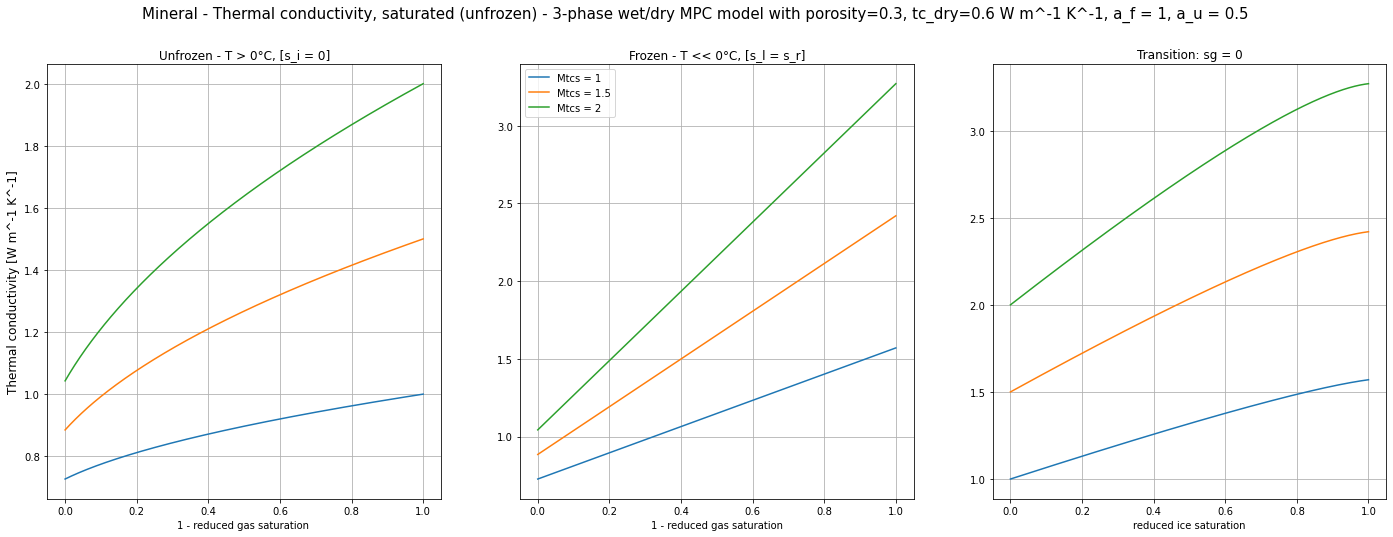

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(24, 8)
fig.suptitle(f'Mineral - Thermal conductivity, saturated (unfrozen) - 3-phase wet/dry MPC model with porosity={Mpor_std}, tc_dry={Mtcd_std} W m^-1 K^-1, a_f = {Maf_std}, a_u = {Mauf_std}', fontsize=15)

# Defining a color label
color_label_water = colors.cm_mapper(vmin=0.0, vmax=3.0, cmap=colors.water_cmap())

# Defining the number of points for the variation of saturation of liquid
npoints = 1000
# Residual saturation
s_r = 0.1

    
# unfrozen
sle = np.linspace(0, 1, npoints)
sl = sle*(1-s_r) + s_r
si = 0

for i, value in enumerate(Mtcs):
    locals()[f'tc_Mtcs_u_{i}'] = np.array([globals()[f'tc_Mtcs_{i}'].thermal_conductivity(Mpor_std, s, si, 275.) for s in sl])
    ax1.plot(sle, locals()[f'tc_Mtcs_u_{i}'], label=f'Mtcs = {value}')

ax1.set_xlabel("1 - reduced gas saturation ")
ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]", fontsize=12)
ax1.grid(True)
#ax1.legend()

# frozen
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

for i, value in enumerate(Mtcs):
    locals()[f'tc_Mtcs_f_{i}'] = np.array([globals()[f'tc_Mtcs_{i}'].thermal_conductivity(Mpor_std, s_r, s, 260.0) for s in si])
    ax2.plot(sle, locals()[f'tc_Mtcs_f_{i}'], label=f'Mtcs = {value}')
ax2.set_xlabel("1 - reduced gas saturation")
ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
ax2.grid(True)
ax2.legend()
#ax3.set_ylabel("thermal conductivity")

# transition
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

for i, value in enumerate(Mtcs):
    locals()[f'tc_Mtcs_t_{i}'] = np.array([globals()[f'tc_Mtcs_{i}'].thermal_conductivity(Mpor_std, 1-s, s, 260.0) for s in si])
    ax3.plot(sle, locals()[f'tc_Mtcs_t_{i}'], label=f'Mtcs = {value}')
    

ax3.set_xlabel("reduced ice saturation")
#ax3.set_ylabel("thermal conductivity")
ax3.set_title("Transition: sg = 0")
#ax3.legend()
ax3.grid(True)

#### Similarly it can be plotted for Bedrock

### Thermal conductivity, dry 

### Peat

In [66]:
Ptcd

[0.03, 0.07, 0.12]

In [67]:
# Generating the objects for different thermal conductivity value, saturated (unfrozen)
for i, value in enumerate(Ptcd):
    locals()[f'tc_Ptcd_{i}'] = ThreePhaseWetDry(Ptcs_std, value, Paf_std, Pauf_std)

In [68]:
tc_Ptcd_2.tc_dry

0.12

(0.0, 1.3)

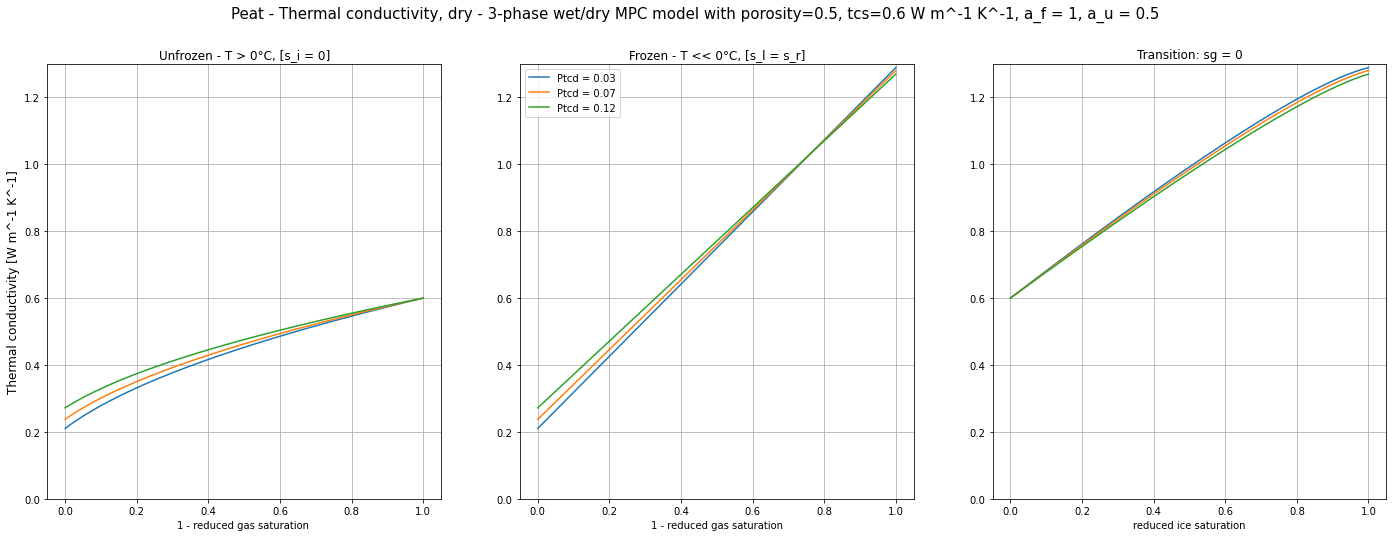

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(24, 8)
fig.suptitle(f'Peat - Thermal conductivity, dry - 3-phase wet/dry MPC model with porosity={Ppor_std}, tcs={Ptcs_std} W m^-1 K^-1, a_f = {Paf_std}, a_u = {Pauf_std}', fontsize=15)

# Defining a color label
color_label_water = colors.cm_mapper(vmin=0.0, vmax=3.0, cmap=colors.water_cmap())

# Defining the number of points for the variation of saturation of liquid
npoints = 1000
# Residual saturation
s_r = 0.1

    
# unfrozen
sle = np.linspace(0, 1, npoints)
sl = sle*(1-s_r) + s_r
si = 0

for i, value in enumerate(Ptcd):
    locals()[f'tc_Ptcd_u_{i}'] = np.array([globals()[f'tc_Ptcd_{i}'].thermal_conductivity(Ppor_std, s, si, 275.) for s in sl])
    ax1.plot(sle, locals()[f'tc_Ptcd_u_{i}'], label=f'Ptcd = {value}')

ax1.set_xlabel("1 - reduced gas saturation ")
ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]", fontsize=12)
ax1.grid(True)
#ax1.legend()
ax1.set_ylim(0, 1.3)

# frozen
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

for i, value in enumerate(Ptcd):
    locals()[f'tc_Ptcd_f_{i}'] = np.array([globals()[f'tc_Ptcd_{i}'].thermal_conductivity(Ppor_std, s_r, s, 260.0) for s in si])
    ax2.plot(sle, locals()[f'tc_Ptcd_f_{i}'], label=f'Ptcd = {value}')
ax2.set_xlabel("1 - reduced gas saturation")
ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
ax2.grid(True)
ax2.legend()
#ax3.set_ylabel("thermal conductivity")
ax2.set_ylim(0, 1.3)

# transition
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

for i, value in enumerate(Ptcd):
    locals()[f'tc_Ptcd_t_{i}'] = np.array([globals()[f'tc_Ptcd_{i}'].thermal_conductivity(Ppor_std, 1-s, s, 260.0) for s in si])
    ax3.plot(sle, locals()[f'tc_Ptcd_t_{i}'], label=f'Ptcd = {value}')
    

ax3.set_xlabel("reduced ice saturation")
#ax3.set_ylabel("thermal conductivity")
ax3.set_title("Transition: sg = 0")
#ax3.legend()
ax3.grid(True)
ax3.set_ylim(0, 1.3)

#### Comments:
- The effects of dry thermal conductivity is less compared to the saturated (unfrozen) thermal conductivity
- The starting tc are affected for the frozen and unfrozen state. In the transition state, the final tc varies
- As the thermal conductivity, dry increases  the total tc also increases, however to not a greater extent. It‘s influences reduces as the saturation of liquid increases.


### Mineral

In [70]:
Mtcd

[0.2, 0.6, 1.0]

In [71]:
# Generating the objects for different thermal conductivity value, saturated (unfrozen)
for i, value in enumerate(Mtcd):
    locals()[f'tc_Mtcd_{i}'] = ThreePhaseWetDry(Mtcs_std, value, Maf_std, Mauf_std)

In [72]:
tc_Mtcd_2.tc_dry

1.0

(0.0, 2.5)

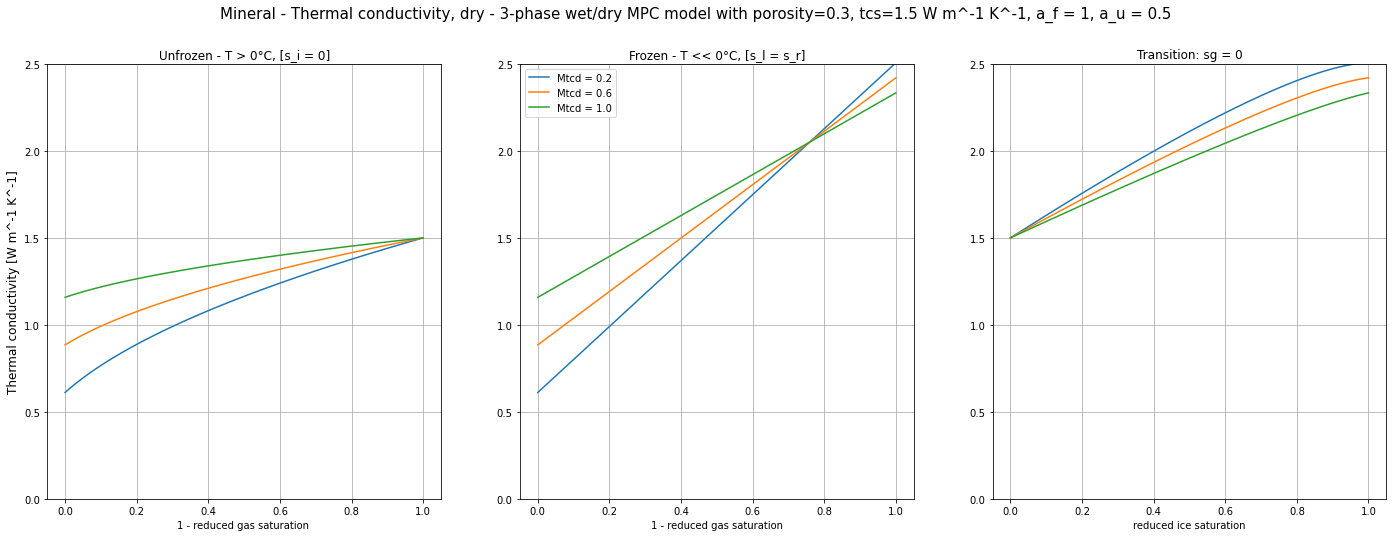

In [84]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(24, 8)
fig.suptitle(f'Mineral - Thermal conductivity, dry - 3-phase wet/dry MPC model with porosity={Mpor_std}, tcs={Mtcs_std} W m^-1 K^-1, a_f = {Maf_std}, a_u = {Mauf_std}', fontsize=15)

# Defining a color label
color_label_water = colors.cm_mapper(vmin=0.0, vmax=3.0, cmap=colors.water_cmap())

# Defining the number of points for the variation of saturation of liquid
npoints = 1000
# Residual saturation
s_r = 0.1

    
# unfrozen
sle = np.linspace(0, 1, npoints)
sl = sle*(1-s_r) + s_r
si = 0

for i, value in enumerate(Mtcd):
    locals()[f'tc_Mtcd_u_{i}'] = np.array([globals()[f'tc_Mtcd_{i}'].thermal_conductivity(Mpor_std, s, si, 275.) for s in sl])
    ax1.plot(sle, locals()[f'tc_Mtcd_u_{i}'], label=f'Mtcd = {value}')

ax1.set_xlabel("1 - reduced gas saturation ")
ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]", fontsize=12)
ax1.grid(True)
#ax1.legend()
ax1.set_ylim(0, 2.5)

# frozen
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

for i, value in enumerate(Mtcd):
    locals()[f'tc_Mtcd_f_{i}'] = np.array([globals()[f'tc_Mtcd_{i}'].thermal_conductivity(Mpor_std, s_r, s, 260.0) for s in si])
    ax2.plot(sle, locals()[f'tc_Mtcd_f_{i}'], label=f'Mtcd = {value}')
ax2.set_xlabel("1 - reduced gas saturation")
ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
ax2.grid(True)
ax2.legend()
#ax3.set_ylabel("thermal conductivity")
ax2.set_ylim(0, 2.5)

# transition
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

for i, value in enumerate(Mtcd):
    locals()[f'tc_Mtcd_t_{i}'] = np.array([globals()[f'tc_Mtcd_{i}'].thermal_conductivity(Mpor_std, 1-s, s, 260.0) for s in si])
    ax3.plot(sle, locals()[f'tc_Mtcd_t_{i}'], label=f'Mtcd = {value}')
    

ax3.set_xlabel("reduced ice saturation")
#ax3.set_ylabel("thermal conductivity")
ax3.set_title("Transition: sg = 0")
#ax3.legend()
ax3.grid(True)
ax3.set_ylim(0, 2.5)

### Similarly for bedrock it can be done

### Alpha saturated frozen

### Peat

In [153]:
Paf

[0.5, 1.0, 1.5]

In [154]:
# Generating the objects for different thermal conductivity value, saturated (frozen)
for i, value in enumerate(Paf):
    #print(i, value)
    locals()[f'tc_Paf_{i}'] = ThreePhaseWetDry(Ptcs_std, Ptcd_std, value, Pauf_std)

In [155]:
tc_Paf_2.a_f

1.5

(0.0, 1.5)

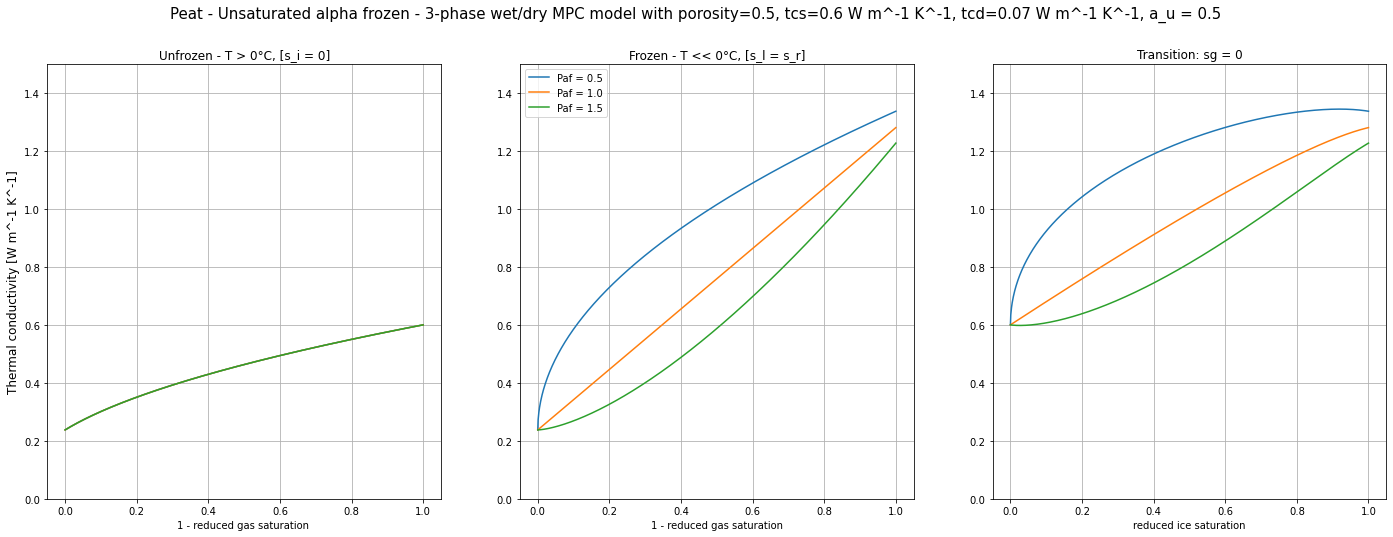

In [157]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(24, 8)
fig.suptitle(f'Peat - Unsaturated alpha frozen - 3-phase wet/dry MPC model with porosity={Ppor_std}, tcs={Ptcs_std} W m^-1 K^-1, tcd={Ptcd_std} W m^-1 K^-1, a_u = {Pauf_std}', fontsize=15)

# Defining a color label
color_label_water = colors.cm_mapper(vmin=0.0, vmax=3.0, cmap=colors.water_cmap())

# Defining the number of points for the variation of saturation of liquid
npoints = 1000
# Residual saturation
s_r = 0.1

    
# unfrozen
sle = np.linspace(0, 1, npoints)
sl = sle*(1-s_r) + s_r
si = 0

for i, value in enumerate(Paf):
    locals()[f'tc_Paf_u_{i}'] = np.array([globals()[f'tc_Paf_{i}'].thermal_conductivity(Ppor_std, s, si, 275.) for s in sl])
    ax1.plot(sle, locals()[f'tc_Paf_u_{i}'], label=f'Paf = {value}')

ax1.set_xlabel("1 - reduced gas saturation ")
ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]", fontsize=12)
ax1.grid(True)
#ax1.legend()
ax1.set_ylim(0, 1.5)

# frozen
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

for i, value in enumerate(Paf):
    locals()[f'tc_Paf_f_{i}'] = np.array([globals()[f'tc_Paf_{i}'].thermal_conductivity(Ppor_std, s_r, s, 260.0) for s in si])
    ax2.plot(sle, locals()[f'tc_Paf_f_{i}'], label=f'Paf = {value}')
ax2.set_xlabel("1 - reduced gas saturation")
ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
ax2.grid(True)
ax2.legend()
#ax3.set_ylabel("thermal conductivity")
ax2.set_ylim(0, 1.5)

# transition
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

for i, value in enumerate(Paf):
    locals()[f'tc_Paf_t_{i}'] = np.array([globals()[f'tc_Paf_{i}'].thermal_conductivity(Ppor_std, 1-s, s, 260.0) for s in si])
    ax3.plot(sle, locals()[f'tc_Paf_t_{i}'], label=f'Paf = {value}')
    

ax3.set_xlabel("reduced ice saturation")
#ax3.set_ylabel("thermal conductivity")
ax3.set_title("Transition: sg = 0")
#ax3.legend()
ax3.grid(True)
ax3.set_ylim(0, 1.5)

Comments:

- Greater the alpha frozen value, lower the overall tc value. With the higher alpha frozen value, the kersten number reduces and hence the final tc also reduces
- At the unfrozen state, the change in alpha frozen value does not impact the tc. 

### Similarly we can plot for mineral and bedrock

### Alpha saturated unfrozen

### Peat

In [161]:
Pauf

[0.1, 0.5, 0.7]

In [162]:
# Generating the objects for different thermal conductivity value, saturated (unfrozen)
for i, value in enumerate(Pauf):
    #print(i, value)
    locals()[f'tc_Pauf_{i}'] = ThreePhaseWetDry(Ptcs_std, Ptcd_std, Paf_std, value)

In [165]:
tc_Pauf_2.a_u

0.7

(0.0, 1.8)

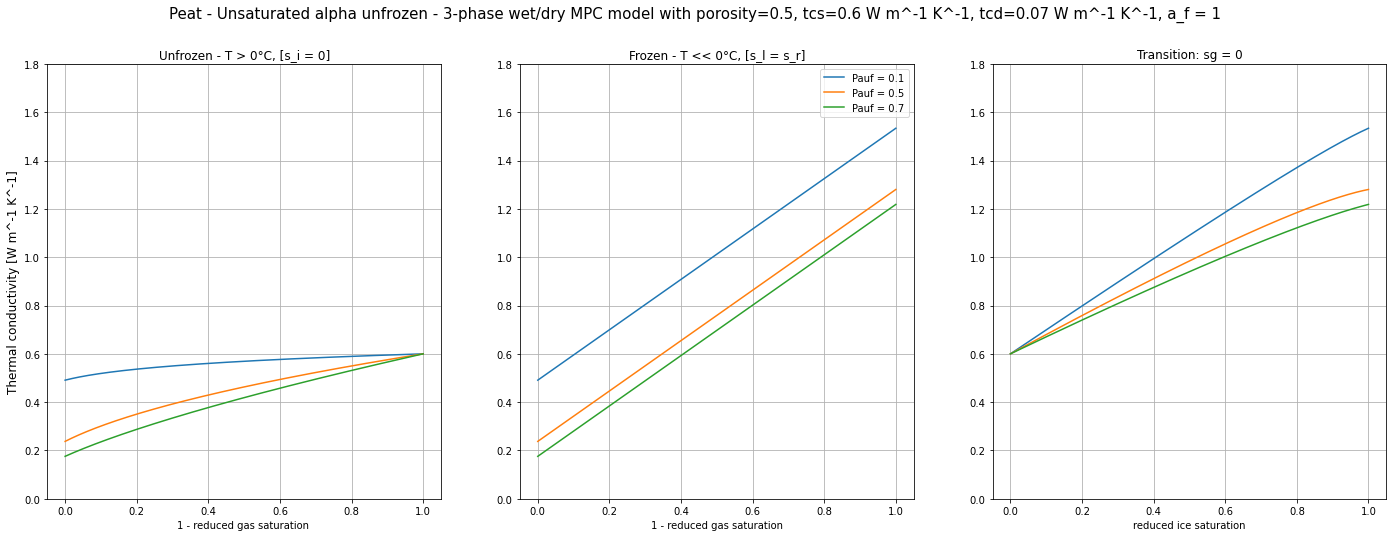

In [167]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(24, 8)
fig.suptitle(f'Peat - Unsaturated alpha unfrozen - 3-phase wet/dry MPC model with porosity={Ppor_std}, tcs={Ptcs_std} W m^-1 K^-1, tcd={Ptcd_std} W m^-1 K^-1, a_f = {Paf_std}', fontsize=15)

# Defining a color label
color_label_water = colors.cm_mapper(vmin=0.0, vmax=3.0, cmap=colors.water_cmap())

# Defining the number of points for the variation of saturation of liquid
npoints = 1000
# Residual saturation
s_r = 0.1

    
# unfrozen
sle = np.linspace(0, 1, npoints)
sl = sle*(1-s_r) + s_r
si = 0

for i, value in enumerate(Pauf):
    locals()[f'tc_Pauf_u_{i}'] = np.array([globals()[f'tc_Pauf_{i}'].thermal_conductivity(Ppor_std, s, si, 275.) for s in sl])
    ax1.plot(sle, locals()[f'tc_Pauf_u_{i}'], label=f'Pauf = {value}')

ax1.set_xlabel("1 - reduced gas saturation ")
ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]", fontsize=12)
ax1.grid(True)
#ax1.legend()
ax1.set_ylim(0, 1.8)

# frozen
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

for i, value in enumerate(Pauf):
    locals()[f'tc_Pauf_f_{i}'] = np.array([globals()[f'tc_Pauf_{i}'].thermal_conductivity(Ppor_std, s_r, s, 260.0) for s in si])
    ax2.plot(sle, locals()[f'tc_Pauf_f_{i}'], label=f'Pauf = {value}')
ax2.set_xlabel("1 - reduced gas saturation")
ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
ax2.grid(True)
ax2.legend()
#ax3.set_ylabel("thermal conductivity")
ax2.set_ylim(0, 1.8)

# transition
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

for i, value in enumerate(Pauf):
    locals()[f'tc_Pauf_t_{i}'] = np.array([globals()[f'tc_Pauf_{i}'].thermal_conductivity(Ppor_std, 1-s, s, 260.0) for s in si])
    ax3.plot(sle, locals()[f'tc_Pauf_t_{i}'], label=f'Pauf = {value}')
    

ax3.set_xlabel("reduced ice saturation")
#ax3.set_ylabel("thermal conductivity")
ax3.set_title("Transition: sg = 0")
#ax3.legend()
ax3.grid(True)
ax3.set_ylim(0, 1.8)

Comments:
- Greater the alpha unfrozen value, lower the overall tc value. With the higher alpha frozen value, the kersten number reduces and hence the final tc also reduces
- At the unfrozen state, the change in alpha frozen value does not impact the tc. 

### Similarly we can plot for mineral and bedrock